# <center> Feature Engineering and Modelling </center>

<center> Notebook Two: <br>
Features, Targets, Modelling, Training, Testing, and Parameter Optimization </center>

Prepared by: Behrouz ShakeriFard

contact: bshakeri@ryerson.ca

July 2022

In the previous notebook we saw the basic fluctuations of our main variables of interest (market demand, system's output, output/capacity ratio, and price) in a 24-hour cycle. We will now begin to investigate possible avenues to learn from the data, and along the way we will engineer new features and define a target, which we would like to predict.

In [1]:
# importing a few useful packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import style
from pylab import *

from scipy.stats import linregress

In [2]:
# importing data
old_df = pd.read_csv('data_step_one.csv')

In [3]:
# sanity check
old_df.head()

,Unnamed: 0,Date,Hour,Market Demand,Output,Capacity,Output/Cap ratio,Price
0,3,2018-01-01,1,18662.0,17974.0,28583.0,0.628835,51.29
1,4,2018-01-01,2,18060.0,17797.0,29352.0,0.606330,43.59
2,5,2018-01-01,3,18429.0,18044.0,29590.0,0.609801,93.60
3,6,2018-01-01,4,19137.0,19004.0,29902.0,0.635543,54.78
4,7,2018-01-01,5,19470.0,19280.0,30079.0,0.640979,14.35


In [4]:
old_df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
# sanity check
old_df.head()

,Date,Hour,Market Demand,Output,Capacity,Output/Cap ratio,Price
0,2018-01-01,1,18662.0,17974.0,28583.0,0.628835,51.29
1,2018-01-01,2,18060.0,17797.0,29352.0,0.606330,43.59
2,2018-01-01,3,18429.0,18044.0,29590.0,0.609801,93.60
3,2018-01-01,4,19137.0,19004.0,29902.0,0.635543,54.78
4,2018-01-01,5,19470.0,19280.0,30079.0,0.640979,14.35


In [6]:
# sanity check
old_df.shape

(8760, 7)

##  Our Pupose at a Glance

Data science is a field that utilizes vast pools of data, in order to extract insight, produce avenues for hypothesis testing, and assist decision making. All of the above may be useful in private enterprise, as well as governmental agencies, non-for-profits, non-governmental organizations, households, and even entreprenuers.

The data which we are looking at, presents a business opportunity. Therefore, I would rather present the question in form of entreprenuership opportunity rather than a business problem. Although the later applies as well.

## Defining the Challenge

This analysis seeks to identify the best machine learning technique for predicting binary outcome, which we will construct using the IESO data. This binary outcome indicates when a building (residential or commercial) equipped with adequate electricity storage would disengage from the electricity grid, in order to stop buying electricity from the grid.

This is useful because large fluctuations in price - in particular during peak hours - can become heavy financial burdens for large consumers (such as apartment blocks or commercial plants for food processing, manufacturing, assembly, or other activities).

For this purpose, we need to look beyond the few features that we currently have.

## Feature Engineering


Understanding the market is key. The features that we currently poses are not tremendously useful. Therefore, we will gradually add more and more features.


In [7]:
data_x = pd.DataFrame()

In [10]:
data_x = old_df[['Date','Hour','Market Demand','Output','Output/Cap ratio']]

data_x.dtypes

Date                 object
Hour                  int64
Market Demand       float64
Output              float64
Output/Cap ratio    float64
dtype: object

### First added feature: Market Surplus

Electricity market is rarely in equilibrium; and this disequilibrium carries valuable information. In order to extract this  information we will deduct demand from output, and we will cal this column *Market Surplus* because deducting demand from output would produce a positive figure, reflecting the surplus electricity (or energy) that exists in the system. On the other hand, if the system experience a shortage, this variable would turn negative.

In [12]:
data_x['MarketSurplus'] = data_x['Output'] - data_x['Market Demand']

C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\3187022151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x['MarketSurplus'] = data_x['Output'] - data_x['Market Demand']


In [13]:
# sanity check
data_x.sample(7)

,Date,Hour,Market Demand,Output,Output/Cap ratio,MarketSurplus
1553,2018-03-06,18,19790.0,18207.0,0.666069,-1583.0
1768,2018-03-15,17,19019.0,17565.0,0.618072,-1454.0
8067,2018-12-03,4,17559.0,17174.0,0.587025,-385.0
6625,2018-10-04,2,14401.0,14214.0,0.497707,-187.0
8606,2018-12-25,15,17946.0,16636.0,0.589866,-1310.0
4201,2018-06-25,2,14604.0,14213.0,0.498562,-391.0
2779,2018-04-26,20,15408.0,14603.0,0.563627,-805.0


## Second Added Feature: Year-on-Year Surplus

Market prices reflect (to some extent) deviations of the current transactions from the expectations. In other words, surprises in the electricity consumption behavior will lead to surprises in the prices.

In order to capture this, we will import previous year's demand data, and deduct our current demand from that of a year before, in order to see whether or not there is significant deviation in consumers' behavior.

In [14]:
# importing data
d_2017 = pd.read_csv('PUB_Demand_2017_v1.csv')

In [15]:
# sanity check
d_2017.head()

,\\Hourly Demand Report,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,\\Created at 2018-05-22 08:00:00,NaN,NaN,NaN
1,\\For 2017,NaN,NaN,NaN
2,Date,Hour,Market Demand,Ontario Demand
3,2017-01-01,1,17172,13522
4,2017-01-01,2,16757,13117


In [17]:
# renaming columns
d_2017.columns=['Date', 'Hour','Market Demand','Ontario Demand']

In [18]:
# dropping rows that contain unuseful information
d_2017.drop([0,1,2], inplace = True)

In [19]:
#sanity check
d_2017.head()

,Date,Hour,Market Demand,Ontario Demand
3,2017-01-01,1,17172,13522
4,2017-01-01,2,16757,13117
5,2017-01-01,3,16370,12816
6,2017-01-01,4,16075,12605
7,2017-01-01,5,16050,12563


In [21]:
d_2017['Market Demand'] = d_2017['Market Demand'].apply(pd.to_numeric)

# operation
data_x['yr-on-yr Surplus'] = d_2017['Market Demand'] - data_x['Market Demand']

In [22]:
#sanity check
data_x.sample(7)

,Date,Hour,Market Demand,Output,Output/Cap ratio,MarketSurplus,yr-on-yr Surplus
6247,2018-09-18,8,19373.0,15268.0,0.729444,-4105.0,-4675.0
4540,2018-07-09,5,18544.0,16957.0,0.620204,-1587.0,-4193.0
3643,2018-06-01,20,17527.0,15679.0,0.575989,-1848.0,-975.0
6306,2018-09-20,19,16953.0,15705.0,0.563671,-1248.0,2994.0
5081,2018-07-31,18,19649.0,17855.0,0.667951,-1794.0,1611.0
6020,2018-09-08,21,14582.0,14321.0,0.505275,-261.0,1433.0
732,2018-01-31,13,21254.0,19501.0,0.619040,-1753.0,-1306.0


For example, row 5081 shows that we have a substatial yr-on-yr surplus (1600 MW), and market demand is not particularly high (less than 20,000 MW). Therefore, we should expect a price that is not an outlier.

In [23]:
old_df.iloc[5081]['Price']

35.2

Furthermore, row 6247 shows there is significant market deficit as well as yr-on-yr deficit, while system operator has utilized more than 70% of its resources to meet the demand. We should expect beyong normal price levels for this instance.

In [24]:
old_df.iloc[6247]['Price']

41.69

This price for relatively early morning is indeed unusual.

For reference, we will take another look at the price distribution.

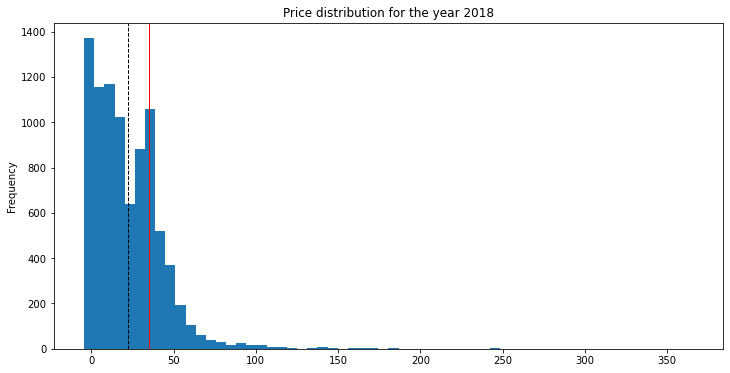

In [33]:
# initiate the plot and setting the size
plt.figure(figsize=(12,6))
old_df['Price'].plot(kind='hist',bins=60)
plt.axvline(old_df['Price'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(35, color='r', linestyle='solid', linewidth=1)
plt.title('Price Distribution for the year 2018')
plt.show()

To Do list:

 * * Surplus (demand and output)
 * Demand trajectory (apply shift to see where is demand going)
 * Surplus trajectory (apply shift to see is the market tending towards equilibrium or against it)
 * output/Capacity value
 * output capacity trajectory
 * * year on year surplus (value)
 * year on year deficit (trajectory)
 
 * demand (value)

Also do these:
 * confusion matrix 1 
 * Model evaluation [2]
 * Up-sampling [3] 
 * Re-run all the models on the shift [4] (1,2,3) 
 
 * Classification report (same lecture as above) ***

In [34]:
# sanity check
data_x.head()

,Date,Hour,Market Demand,Output,Output/Cap ratio,MarketSurplus,yr-on-yr Surplus
0,2018-01-01,1,18662.0,17974.0,0.628835,-688.0,NaN
1,2018-01-01,2,18060.0,17797.0,0.606330,-263.0,NaN
2,2018-01-01,3,18429.0,18044.0,0.609801,-385.0,NaN
3,2018-01-01,4,19137.0,19004.0,0.635543,-133.0,-1965.0
4,2018-01-01,5,19470.0,19280.0,0.640979,-190.0,-2713.0


In [37]:
# sanity check
data_x.isnull().sum()

Date                0
Hour                0
Market Demand       3
Output              3
Output/Cap ratio    3
MarketSurplus       3
yr-on-yr Surplus    6
dtype: int64

We will proceed to fill the missing values with the column's mean value.

In [40]:
# filling the missing values
data_x['yr-on-yr Surplus'].fillna(data_x['yr-on-yr Surplus'].mean(),inplace=True)

In [41]:
# sanity check
data_x.isnull().sum()

Date                0
Hour                0
Market Demand       3
Output              3
Output/Cap ratio    3
MarketSurplus       3
yr-on-yr Surplus    0
dtype: int64

In [42]:
data_x['Market Demand'].fillna(data_x['Market Demand'].mean(),inplace=True)
data_x['Output'].fillna(data_x['Output'].mean(),inplace=True)
data_x['Output/Cap ratio'].fillna(data_x['Output/Cap ratio'].mean(),inplace=True)
data_x['MarketSurplus'].fillna(data_x['MarketSurplus'].mean(),inplace=True)

In [43]:
# sanity check
data_x.isnull().sum()

Date                0
Hour                0
Market Demand       0
Output              0
Output/Cap ratio    0
MarketSurplus       0
yr-on-yr Surplus    0
dtype: int64

Now our data is a good starting point for investigating potential relationships between variables. We begin with asserting that simultaneous high Market Demand, high Output/Capacity ratio, with Market deficit and year-on-year deficits, are likely to co-occur with price spikes. We will now create the necessary target for our modelling proceedure.

# <center> Target </center>

Our target is a binary variable, representing whether a connection should exist (buying electricity from the grid) or not (utilizing local electricity storage, in order to save money).

One key challenge with this setting a connectivity threshold. However, for the moment, we will refrain from fine-tuning this variable and start with the simple exercise of creating the binary variable with a non-scientific (non-optimized) threshold.

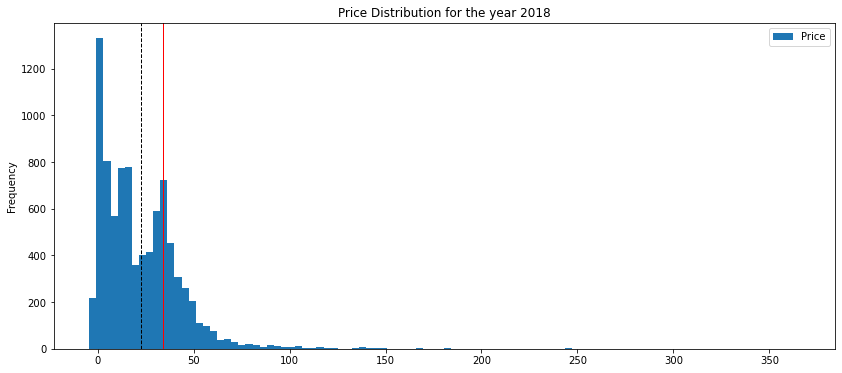

In [49]:
# initiate the plot and setting the size
plt.figure(figsize=(14,6))
old_df['Price'].plot(kind='hist',bins=100)
plt.axvline(old_df['Price'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(34, color='r', linestyle='solid', linewidth=1)
plt.legend(loc = 'upper right')
plt.title('Price Distribution for the year 2018')
plt.show()

In [186]:
# creating a new dataframe
df_target=pd.DataFrame()

# importing price
df_target['Price'] = old_df['Price']

# connect column represents a True or False (binary) variable
df_target['connect'] = df_target.apply(lambda x: int(1) if int(x['Price']) < 40 else int(0), axis=1)

In [51]:
# sanity check
df_target.sample(7)

,Price,connect
5763,42.86,0
368,54.95,0
5326,21.35,1
3960,9.41,1
8241,45.11,0
227,13.34,1
6553,14.31,1


Total instances of price going above 40 dollars for one MWh of electricity

In [52]:
8760 - (df_target['connect'].sum())

1344

In [53]:
# this represents a percentage of ...
(8760 - (df_target['connect'].sum()))/8760 * 100

15.342465753424658

# <center> Modelling </center>

We will begin our modelling with a handful of key variables of interest, and later we will expand on it. For now, these variables are:

* Market Demand
* Market Surplus
* Output/Capacity ratio
* Year-on-Year Surplus


In [59]:
from sklearn.model_selection import train_test_split

In [54]:
data_x_core = pd.DataFrame()

data_x_core = data_x[['Market Demand','MarketSurplus','Output/Cap ratio','yr-on-yr Surplus']]

<AxesSubplot:>

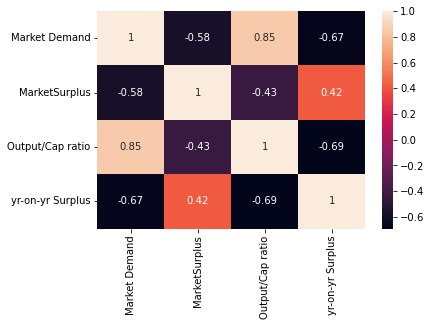

In [56]:
sns.heatmap(data_x_core.corr(),annot=True)

This specification (feature selection) is not ideal, because some of these variables are strongly correlated. Modelling is an iterative process, and our final features may differ from what we start with; and we can't allow such problems to stop us from making progress. So, we soldier on.

Next, we need to split our data into at least two pieces for training and testing.

In [61]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data_x_core, df_target, test_size=0.3)

# Logistic Regression



In [62]:
# importing the package
from sklearn.linear_model import LogisticRegression

In [63]:
# importing the package
from sklearn.preprocessing import StandardScaler

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [74]:
# Fitting the linear model
LR_model = LogisticRegression(C=0.1)
LR_model.fit(X_train_scaled, y_train['connect'])

print(f"The TRAIN classification accuracy is:  {LR_model.score(X_train_scaled,y_train['connect'])}")
print(f"The TEST classification accuracy is:  {LR_model.score(X_test_scaled,y_test['connect'])}")

The TRAIN classification accuracy is:  0.8646444879321592
The TEST classification accuracy is:  0.8626331811263318


In order to evaluate this performance, we need to look at the confusion matrix.

In binary classification, there are four possible outcomes to making a prediction:

1. **True Positive (TP)**: Correctly predict that $x$ belongs to class 1/positive class
2. **False Positive (FP)**: Incorrectly predict that $x$  belongs to class 1/positive class
3. **True Negative (TN)**: Correctly predict $x$'s membership in class 0/negative class 
4. **False Negative (FN)**: Incorrectly predict $x$'s membership in class 0/negative class

If we put these outcomes in a matrix, we arrive at what is known as a confusion matrix:

|     |  Predicted Class 0  |   Predicted Class 1  | 
| --------- |:---:|:---:|
|True Class 0|**TN** | **FP** | 
|True Class 1|**FN** |**TP** | 

Using these definitions, accuracy can be written as:

$$Accuracy = \frac{\text{# correct predictions}}{\text{# all predictions}}= \frac{TN+TP}{TN+FP+FN+TP}$$

In [75]:
# importing useful packages
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [76]:
y_pred = LR_model.predict(X_test)
confusion_matrix(y_test['connect'], y_pred)

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[ 120,  267],
       [ 909, 1332]], dtype=int64)

This model is trying to predict class 0 (meaning disconnect) in order to help customers save on their electricity bills. In this example, we have only identified this correctly 120 times. Which is why we need to improve things substatially.

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


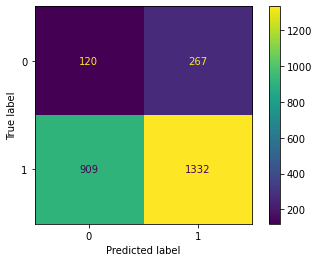

In [77]:
plot_confusion_matrix(LR_model, X_test, y_test['connect'])

We need to minimize False positives, because they are instances when prise has gone beyong our threshhold, and our forecast model has failed to see them happening. This will be our area of focus.

|     |  Predicted Class 0  |   Predicted Class 1  | 
| --------- |:---:|:---:|
|True Class 0|**TN** | **FP** | 
|True Class 1|**FN** |**TP** | 

## Hyper parameter optimization

For this step, we need further split our data: about 20 percent for testing, and 80% for hyper-parameter optimization. This 80% (the remainder) will be further split into two chunks: 70% training, and 30% validation.

In [78]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(data_x_core, df_target['connect'], test_size = 0.2,random_state=1)

In [79]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

In [80]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1752, 4)
Shape of validation set: (2103, 4)
Shape of train set: (4905, 4)


In [87]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.fit_transform(X_validation)
X_test_scaled = scaler.fit_transform(X_test)

In [81]:
print(f'Shape of test set: {y_test.shape}')
print(f'Shape of validation set: {y_validation.shape}')
print(f'Shape of train set: {y_train.shape}')

Shape of test set: (1752,)
Shape of validation set: (2103,)
Shape of train set: (4905,)


In [84]:
y_validation.mean()

0.8478364241559677

In [88]:
validation_scores = []
train_scores = []

# this variable is the key variable in Logistic Regression performance, and we seek to find an optimum point
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# this loop iterates through different C values
for c in C_range:
    my_logreg = LogisticRegression(C=c, random_state=1)
    my_logreg.fit(X_train_scaled, y_train)
    
    # train on traning set
    train_scores.append(my_logreg.score(X_train_scaled, y_train))

    # score on validation set
    validation_scores.append(my_logreg.score(X_validation_scaled, y_validation))
    

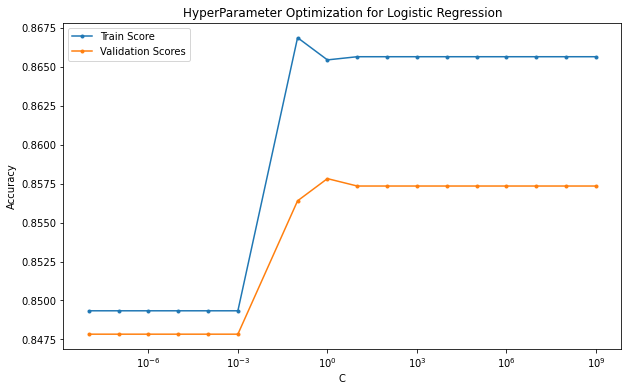

In [90]:
# initiating the plot
plt.figure(figsize=(10, 6))
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('HyperParameter Optimization for Logistic Regression')
plt.legend()
plt.show();

Best results can be obtained by setting parameter C equal to 1.

In [98]:
# Fitting the linear model
LR_model = LogisticRegression(C=1)
LR_model.fit(X_train_scaled, y_train)

print(f"The TRAIN classification accuracy is:  {LR_model.score(X_train_scaled,y_train)}")
print(f"The TEST classification accuracy is:  {LR_model.score(X_test_scaled,y_test)}")

The TRAIN classification accuracy is:  0.8654434250764526
The TEST classification accuracy is:  0.8584474885844748


In [101]:
y_validation.mean()

0.8478364241559677

This result is not particularly impressive. The validation dataset that we have, indicates that 84.7% of the time connection to the grid is beneficial. The accuracy of our model is 85.8%, which means if we did not have a model, we would still be right most of the time. However, we need to understand how closely are our predictions following the necessary NEGATIVE or zero outcomes.

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


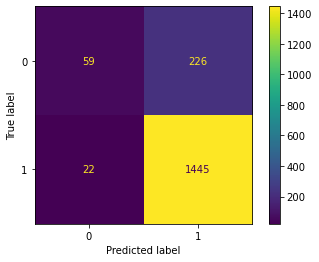

In [103]:
plot_confusion_matrix(LR_model, X_test_scaled, y_test)

|     |  Predicted Class 0  |   Predicted Class 1  | 
| --------- |:---:|:---:|
|True Class 0|**TN** | **FP** | 
|True Class 1|**FN** |**TP** | 

We seek to maximize True Negatives (disconnect because a price spike is likely), while minimizing False positives (remining connected to the grid while a price spike is happening).

In [130]:
print(classification_report(y_test, LR_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.13      0.18      0.15       285
           1       0.83      0.77      0.80      1467

    accuracy                           0.68      1752
   macro avg       0.48      0.48      0.48      1752
weighted avg       0.72      0.68      0.69      1752



C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Because of the fact that accuracy alone can be misleading depending on the class balance of the data, alternative metrics consider the relative proportions of correct and incorrect classifications in both the positive and negative classes. Two of the most common are *precision* and *recall*. 

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives:

$$Recall = \frac{TP}{TP+FN}$$

# Decision Tree



In [104]:
from sklearn.tree import DecisionTreeClassifier

In [106]:
data_x_core.sample(7)

,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus
6468,17825.0,-1670.0,0.643856,1939.0
1821,16277.0,-2058.0,0.545082,2584.0
2649,14269.0,-291.0,0.593520,2612.0
3065,17287.0,-1157.0,0.645458,-2049.0
8223,19731.0,-405.0,0.720447,-337.0
1752,16660.0,-1639.0,0.559046,3145.0
5347,16735.0,-1966.0,0.587447,3589.0


In [187]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data_x_core, df_target['connect'], test_size=0.3)

In [188]:
#Fit to the training data
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  1.0
The TEST classification accuracy is:  0.8116438356164384


This model seems to be overfitting!

In [189]:
#Fit to the training data
DT_model = DecisionTreeClassifier(max_depth=3)
DT_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  0.8608936725375081
The TEST classification accuracy is:  0.8618721461187214


Setting the max_depth parameter to three seems to produce much better results.

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


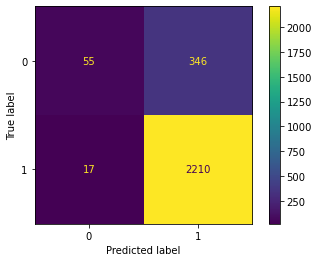

In [190]:
plot_confusion_matrix(DT_model, X_test, y_test)

|     |  Predicted Class 0  |   Predicted Class 1  | 
| --------- |:---:|:---:|
|True Class 0|**TN** | **FP** | 
|True Class 1|**FN** |**TP** | 

In [191]:
print(classification_report(y_test, DT_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.14      0.23       401
           1       0.86      0.99      0.92      2227

    accuracy                           0.86      2628
   macro avg       0.81      0.56      0.58      2628
weighted avg       0.85      0.86      0.82      2628



Because of the fact that accuracy alone can be misleading depending on the class balance of the data, alternative metrics consider the relative proportions of correct and incorrect classifications in both the positive and negative classes. Two of the most common are *precision* and *recall*. 

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives:

$$Recall = \frac{TP}{TP+FN}$$

# Hyper-parameter Optimization

This model is fairly simple and it would be difficult to imagine how excessive depth in the decision making model would benfit the forecast. However, we will (nonetheless) try to optimize this variable.

In [123]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(data_x_core, df_target['connect'], test_size = 0.2,random_state=1)

# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

In [124]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1752, 4)
Shape of validation set: (2103, 4)
Shape of train set: (4905, 4)


In [125]:
validation_scores = []
train_scores = []

max_depth_range = np.arange(1, 15)

for d in max_depth_range:
    print(f"Fitting with max depth {d}", end="\r")
    
    # fit
    model = DecisionTreeClassifier(max_depth=d,)
    model.fit(X_train, y_train)
    
    # score on traning set
    train_scores.append(model.score(X_train, y_train))

    # score on validation set
    validation_scores.append(model.score(X_validation, y_validation))
    

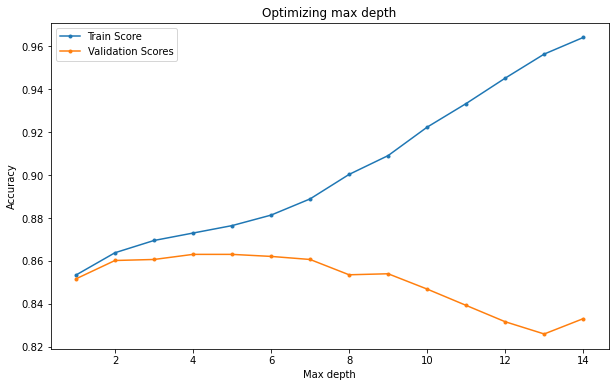

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_scores,label="Train Score",marker='.')
plt.plot(max_depth_range, validation_scores,label="Validation Scores",marker='.')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title("Optimizing max depth")
plt.legend()
# plt.xlim(1, 10)
plt.show();

The desirable outcome is maximizing validation score. In this case, max_depth of 4 and 5 are producing the strongest results.

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


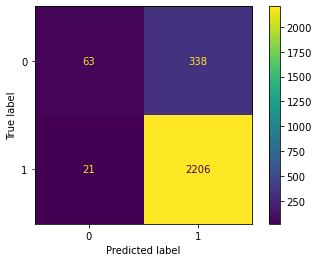

In [192]:
dt_model  = DecisionTreeClassifier(max_depth=4)
dt_model.fit(X_train, y_train)

plot_confusion_matrix(dt_model, X_test, y_test)

In [194]:
print(classification_report(y_test, dt_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.16      0.26       401
           1       0.87      0.99      0.92      2227

    accuracy                           0.86      2628
   macro avg       0.81      0.57      0.59      2628
weighted avg       0.85      0.86      0.82      2628



Changing the max depth from 3 to 4 has improved the prediction a disconnect (True Negative) from 55 to 63 instances.

Because of the fact that accuracy alone can be misleading depending on the class balance of the data, alternative metrics consider the relative proportions of correct and incorrect classifications in both the positive and negative classes. Two of the most common are *precision* and *recall*. 

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives:

$$Recall = \frac{TP}{TP+FN}$$

# Random Forests

The last Machine Learning technique that we want to utilize is random forests. This model tries to over-fit many decision trees and then takes the average of those models and produces forecasts for outcomes.

In [132]:
# importing the package
from sklearn.ensemble import RandomForestClassifier

In [133]:
# making sure we have data stored in X_test and X_train variables
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (1752, 4)
Shape of train set: (4905, 4)


In [134]:
# initiating the model
my_random_forest = RandomForestClassifier(n_estimators=40)
my_random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40)

In [135]:
# Trying different forests

decision_tree_scores = []
for sub_tree in my_random_forest.estimators_:
    decision_tree_scores.append(sub_tree.score(X_train, y_train))
    
print("Performance on fitted data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {my_random_forest.score(X_train, y_train)}")

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier 

Performance on fitted data:
Average Decision Tree: 0.9281243628950051
Random Forest: 0.9983690112130479


C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


We can now use the confusion matrix in order to see how this model has performed.

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


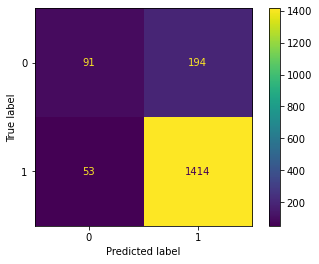

In [137]:
plot_confusion_matrix(my_random_forest, X_test, y_test)

If we put these outcomes in a matrix, we arrive at what is known as a confusion matrix:

|     |  Predicted Class 0  |   Predicted Class 1  | 
| --------- |:---:|:---:|
|True Class 0|**TN** | **FP** | 
|True Class 1|**FN** |**TP** | 

This model is performing well. We would like to err on the side of maximizing True negative at the cost of Flase positives; because, not disconnecting the consumer from the grid during peak prices can defeat the point of having this system. However, False positives would only utilize the storage, which itself is replenished when prices fall.

In [136]:
print(classification_report(y_test, my_random_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.63      0.32      0.42       285
           1       0.88      0.96      0.92      1467

    accuracy                           0.86      1752
   macro avg       0.76      0.64      0.67      1752
weighted avg       0.84      0.86      0.84      1752



Because of the fact that accuracy alone can be misleading depending on the class balance of the data, alternative metrics consider the relative proportions of correct and incorrect classifications in both the positive and negative classes. Two of the most common are *precision* and *recall*. 

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives:

$$Recall = \frac{TP}{TP+FN}$$

# Hyper-parameter Optimization

In [138]:
n_estimater_range = range(1,45)


results = pd.DataFrame()

for n_est in n_estimater_range:
    my_rf = RandomForestClassifier(n_estimators=n_est)
    my_rf.fit(X_train,y_train)
    
    train_score = my_rf.score(X_train,y_train)
    test_score = my_rf.score(X_test,y_test)
    
    results = results.append({'n_estimater':n_est,
                                 'Train':train_score,
                                 'Test': test_score
                             }, ignore_index=True)

C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,
C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,
C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,
C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,


C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,
C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,
C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,
C:\Users\Behro\AppData\Local\Temp\ipykernel_25032\2158074519.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'n_estimater':n_est,


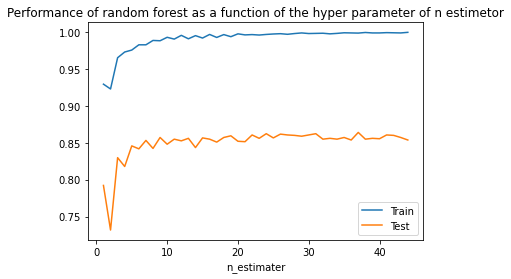

In [139]:
# initiating the plot
plt.figure()
results.plot(x='n_estimater',y=['Train','Test'],ax = plt.gca())
plt.title('Performance of random forest as a function of the hyper parameter of n estimetor')
plt.show()

Of the four features that we have, Output/Capacity ratio seems to be the strongest predictor of a price spike.

In [140]:
my_rf.feature_importances_

array([0.23617223, 0.21655049, 0.32150914, 0.22576814])

In [142]:
data_x_core.sample(9)

,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus
7590,18419.0,-455.0,0.677376,-3369.0
4536,15292.0,-254.0,0.538417,1723.0
942,20298.0,-1549.0,0.667082,-2968.0
4189,17581.0,-633.0,0.593480,-534.0
3492,18956.0,-1651.0,0.664121,-2017.0
5545,15525.0,-529.0,0.554278,601.0
7693,18317.0,-1084.0,0.636209,-477.0
2875,15407.0,-393.0,0.524287,1454.0
2550,18274.0,-1138.0,0.665321,-4753.0


# Shifts

We are investigating variables that change over time; therefore, using shift allows us to add more columns with "lags". These lags indicate changes of these variables over time, and may help our models perform better.

In [143]:
new_data = pd.concat([data_x_core.shift(1), data_x_core], axis=1)

In [144]:
# sanity check
new_data

,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus
0,NaN,NaN,NaN,NaN,18662.000000,-688.000000,0.628835,-579.440484
1,18662.000000,-688.000000,0.628835,-579.440484,18060.000000,-263.000000,0.606330,-579.440484
2,18060.000000,-263.000000,0.606330,-579.440484,18429.000000,-385.000000,0.609801,-579.440484
3,18429.000000,-385.000000,0.609801,-579.440484,19137.000000,-133.000000,0.635543,-1965.000000
4,19137.000000,-133.000000,0.635543,-1965.000000,19470.000000,-190.000000,0.640979,-2713.000000
...,...,...,...,...,...,...,...,...
8755,17516.000000,-289.000000,0.555423,3636.000000,17506.000000,-274.000000,0.559717,4693.000000
8756,17506.000000,-274.000000,0.559717,4693.000000,16704.000000,-204.000000,0.521855,6800.000000
8757,16704.000000,-204.000000,0.521855,6800.000000,17765.890031,-1050.334475,0.613991,-579.440484
8758,17765.890031,-1050.334475,0.613991,-579.440484,17765.890031,-1050.334475,0.613991,-579.440484


In [152]:
# second shift
new_data = pd.concat([new_data.shift(1), data_x_core], axis=1)

In [153]:
# sanity check
new_data.head()

,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus,Market Demand,MarketSurplus,Output/Cap ratio,yr-on-yr Surplus
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18662.0,-688.0,0.628835,-579.440484
1,NaN,NaN,NaN,NaN,18662.0,-688.0,0.628835,-579.440484,18060.0,-263.0,0.606330,-579.440484
2,18662.0,-688.0,0.628835,-579.440484,18060.0,-263.0,0.606330,-579.440484,18429.0,-385.0,0.609801,-579.440484
3,18060.0,-263.0,0.606330,-579.440484,18429.0,-385.0,0.609801,-579.440484,19137.0,-133.0,0.635543,-1965.000000
4,18429.0,-385.0,0.609801,-579.440484,19137.0,-133.0,0.635543,-1965.000000,19470.0,-190.0,0.640979,-2713.000000


In [154]:
# dropping all rows with NaN
new_data = new_data.dropna()

In [155]:
# sanity check
new_data.isna().sum()

Market Demand       0
MarketSurplus       0
Output/Cap ratio    0
yr-on-yr Surplus    0
Market Demand       0
MarketSurplus       0
Output/Cap ratio    0
yr-on-yr Surplus    0
Market Demand       0
MarketSurplus       0
Output/Cap ratio    0
yr-on-yr Surplus    0
dtype: int64

We may now run all of our models again to see if this has helped.

# Logistic Regression

In [195]:
df_target.shape

(8760, 2)

In [196]:
df_target = df_target.drop(0)

In [197]:
df_target = df_target.drop(1)

In [198]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(new_data, df_target, test_size=0.3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


# Fitting the linear model
LR_model = LogisticRegression(C=0.1)
LR_model.fit(X_train_scaled, y_train['connect'])

print(f"The TRAIN classification accuracy is:  {LR_model.score(X_train_scaled,y_train['connect'])}")
print(f"The TEST classification accuracy is:  {LR_model.score(X_test_scaled,y_test['connect'])}")

The TRAIN classification accuracy is:  0.8895595432300163
The TEST classification accuracy is:  0.8801369863013698


C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


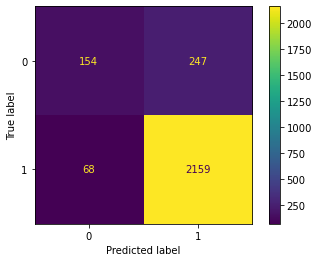

In [199]:
plot_confusion_matrix(LR_model, X_test_scaled, y_test['connect'])

we have slightly better results, after adding more data from the past.

# Decision Tree

In [167]:
X_train.shape

(6130, 12)

In [168]:
y_train.shape

(6130, 2)

In [169]:
y_train.head()

,Price,connect
2399,14.37,1
4419,14.34,1
48,2.31,1
3397,28.06,1
501,33.44,1


In [171]:
#Fit to the training data
DT_model = DecisionTreeClassifier(max_depth=4)
DT_model.fit(X_train, y_train['connect'])

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train['connect'])}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test['connect'])}")

The TRAIN classification accuracy is:  0.8910277324632953
The TEST classification accuracy is:  0.882420091324201


C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


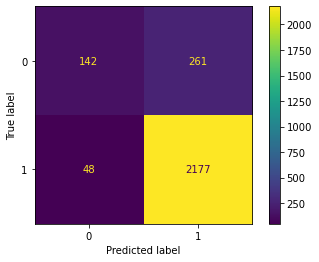

In [178]:
plot_confusion_matrix(DT_model, X_test, y_test['connect'])

In [184]:
print(classification_report(y_test['connect'], DT_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.35      0.48       403
           1       0.89      0.98      0.93      2225

    accuracy                           0.88      2628
   macro avg       0.82      0.67      0.71      2628
weighted avg       0.87      0.88      0.86      2628



The performance of Decision Tree has improved as well.

# Random Forests

In [172]:
# initiating the model
my_random_forest = RandomForestClassifier(n_estimators=40)
my_random_forest.fit(X_train, y_train['connect'])

RandomForestClassifier(n_estimators=40)

In [173]:
# Trying different forests

decision_tree_scores = []
for sub_tree in my_random_forest.estimators_:
    decision_tree_scores.append(sub_tree.score(X_train, y_train['connect']))
    
print("Performance on fitted data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {my_random_forest.score(X_train, y_train['connect'])}")

C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Behro\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier 

Performance on fitted data:
Average Decision Tree: 0.9390456769983686
Random Forest: 1.0


C:\Users\Behro\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


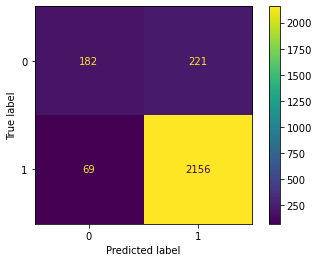

In [175]:
plot_confusion_matrix(my_random_forest, X_test, y_test['connect'])

In [176]:
print(classification_report(y_test['connect'], my_random_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.45      0.56       403
           1       0.91      0.97      0.94      2225

    accuracy                           0.89      2628
   macro avg       0.82      0.71      0.75      2628
weighted avg       0.88      0.89      0.88      2628



Random forests performance has improved significantly.

# Concluding Remarks

All three models perform, but none of the three models are perfect. Hyper-parameter optimization has improved the performance of models; however, there is a lot more that can be done in order to achieve the best performance.

There is strong co-linearity between two of our variables (market demand and output/capacity ratio). One of the two needs to be dropped.

Shifts have also improved performance of our models. Another avenue that is worth exploring, is constructing a variable that follows trajectory of the movements of our features.

Last but not least, we are dealing with a highly imbalance data set. In order to address this issue, we could use upsampling technique.

For future investigations, utilizing neural networks is yet another avenue that is worth exploring.

This investigation can continue further.

July 3rd, 2022.